In [ ]:
import pandas as pd 
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("CarlAxel@1417")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)


In [ ]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql),conn)

In [ ]:
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

## Uppgift 1:
## Antal produkter per kategori
## Affärsfråga: Hur många produkter finns i varje kategori?

query_1 = """
SELECT 
    COALESCE (pc.Name, 'Saknar kategori') AS Kategori,
    COUNT(p.ProductID) AS AntalProdukter
FROM 
    Production.Product p
LEFT JOIN Production.ProductSubcategory ps 
    ON p.ProductSubcategoryID = ps.ProductSubcategoryID
LEFT JOIN Production.ProductCategory pc 
    ON ps.ProductCategoryID = pc.ProductCategoryID
GROUP BY 
    COALESCE(pc.Name, 'Saknar kategori')
ORDER BY 
    CASE WHEN COALESCE(pc.Name, 'Saknar kategori') = 'Saknar kategori' THEN 1 ELSE 0 END,
    AntalProdukter DESC
"""
query_1_df = query_df(query_1)
# display(query_1_df)

colors = [
    "tab:orange" if kategori == "Saknar kategori" else "tab:blue"
    for kategori in query_1_df["Kategori"]
]
plt.figure(figsize=(6, 4))
bars = plt.bar(query_1_df["Kategori"], query_1_df["AntalProdukter"], color=colors)
plt.title("Antal produkter per kategori")
plt.xlabel("Kategori")
plt.ylabel("Antal produkter")
plt.xticks(rotation=45, ha="right")

#Etiketter
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{int(height)}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

## Uppgift 2:
## Försäljning per produktkategori
## Affärsfråga: Vilka produktkategorier genererar mest intäkter?

query_2 = """
SELECT 
    COALESCE (pc.Name, 'Saknar kategori') AS Kategori,
    SUM(LineTotal) AS SummaKategori
FROM 
    Sales.SalesOrderDetail sod
INNER JOIN Production.Product p
    ON sod.ProductID = p.ProductID
LEFT JOIN Production.ProductSubcategory ps 
    ON p.ProductSubcategoryID = ps.ProductSubcategoryID
LEFT JOIN Production.ProductCategory pc 
    ON ps.ProductCategoryID = pc.ProductCategoryID
GROUP BY 
    COALESCE(pc.Name, 'Saknar kategori')
ORDER BY 
    CASE WHEN COALESCE(pc.Name, 'Saknar kategori') = 'Saknar kategori' THEN 1 ELSE 0 END,
    SummaKategori DESC;
"""

query_2_df = query_df(query_2)
display(query_2_df.style.format({"SummaKategori": "${:,.0f}"}).set_caption("Försäljning per produktkategori (USD)"))

plt.figure(figsize=(7, 4))

bars = plt.barh(
    query_2_df["Kategori"],
    query_2_df["SummaKategori"]
)

plt.title("Total försäljning per produktkategori")
plt.xlabel("Försäljning (MUSD)")
plt.ylabel("Produktkategori")

# Högsta värdet överst
plt.gca().invert_yaxis()

# Vertikala hjälplinjer
plt.grid(axis="x", linestyle="--", alpha=0.6)

#Formattering x-axel
ax = plt.gca()
ax.xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{x/1_000_000:.0f} MUSD")
)
plt.xticks(rotation=30)

# Extra utrymme så texten inte kapas
max_value = query_2_df["SummaKategori"].max()
plt.xlim(0, max_value * 1.2)

# Lägg exakta värden på staplarna
for bar in bars:
    width = bar.get_width()
    plt.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"${width:,.0f}",
        va="center",
        ha="left",
        fontsize=9
    )

plt.tight_layout()
plt.show()

##Försäljningstrend över tid
##Affärsfråga: Hur har försäljningen utvecklats över tid?


In [ ]:
## Uppgift
## Försäljningstrend över tid
## Affärsfråga: Hur har försäljningen utvecklats över tid?

query_3 ="""
SELECT
    DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1) AS OrderMonth,
    SUM(TotalDue) AS TotalForsaljning,
    MIN(CAST(OrderDate AS date)) AS FirstOrderDateInMonth,
    MAX(CAST(OrderDate AS date)) AS LastOrderDateInMonth,
    CASE
        WHEN MIN(CAST(OrderDate AS date)) = DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1)
         AND MAX(CAST(OrderDate AS date)) = EOMONTH(DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1))
        THEN 1 ELSE 0
    END AS IsFullMonth
FROM Sales.SalesOrderHeader
GROUP BY DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1)
ORDER BY OrderMonth;
""" 
query_3_df = query_df(query_3)
#query_3_df.head()
#print(query_3_df.dtypes)

#Gör om datumkolumner från object till datetime
query_3_df["OrderMonth"] = pd.to_datetime(query_3_df["OrderMonth"])
query_3_df["FirstOrderDateInMonth"] = pd.to_datetime(query_3_df["FirstOrderDateInMonth"])
query_3_df["LastOrderDateInMonth"] = pd.to_datetime(query_3_df["LastOrderDateInMonth"])


df_full = query_3_df[query_3_df["IsFullMonth"] == 1].copy() #Filtrera bort ofullständiga månader 
df_full = df_full.sort_values("OrderMonth") #Ska vara sorterad men säkerställer

idx_max = df_full["TotalForsaljning"].idxmax()
highest = df_full.loc[idx_max]
idx_min = df_full["TotalForsaljning"].idxmin()
lowest = df_full.loc[idx_min]

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(
    df_full["OrderMonth"],
    df_full["TotalForsaljning"],
    marker="o"
)


# Legend med högst och lägsta värde
max_label = (
    f"Högsta försäljning: "
    f"{highest['TotalForsaljning']:,.0f} USD "
    f"({highest['OrderMonth'].strftime('%Y-%m')})"
)

min_label = (
    f"Lägsta försäljning: "
    f"{lowest['TotalForsaljning']:,.0f} USD "
    f"({lowest['OrderMonth'].strftime('%Y-%m')})"
)

# Markera punkterna
ax.scatter(highest["OrderMonth"], highest["TotalForsaljning"], s=120, zorder=5, color="darkseagreen", label=max_label)
ax.scatter(lowest["OrderMonth"], lowest["TotalForsaljning"], s=120, zorder=5, color="orange", label=min_label)

ax.legend()


ax.set_title("Försäljningstrend per månad")
#ax.set_xlabel("Tid")

#Formatera y-axeln
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda y, _: f"{y/1_000_000:.1f} MUSD")
)
ax.set_ylabel("Försäljning (MUSD)")
ax.set_ylim(bottom=0)

# Månader som ticklabels
ax.set_xticks(df_full["OrderMonth"])
ax.set_xticklabels(
    df_full["OrderMonth"].dt.strftime("%b"),
    rotation=40, ha="right"
)

ax.grid(True, linestyle="--", alpha=0.4)

years = df_full["OrderMonth"].dt.year.unique() #lista med år i kronolisk ordning

for year in years:
    year_data = df_full[df_full["OrderMonth"].dt.year == year]
    mid_date = year_data["OrderMonth"].iloc[len(year_data) // 2]

    ax.text(
        mid_date, -0.18, # placering under x-axeln
        str(year), ha="center", va="top",
        transform=ax.get_xaxis_transform(),
        fontsize=10, fontweight="bold"
    )

# Vertikala linjer vid årsskiften (brytmarkeringar)
min_year = df_full["OrderMonth"].dt.year.min()
max_year = df_full["OrderMonth"].dt.year.max()

for y in range(min_year + 1, max_year + 1):
    boundary = pd.Timestamp(y, 1, 1)
    # Rita bara om gränsen ligger inom vår tidsperiod
    if df_full["OrderMonth"].min() < boundary < df_full["OrderMonth"].max():
        ax.axvline(boundary, linestyle="--", linewidth=1, alpha=0.8, color="tab:gray")

plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.show()


#--------------------------------------------------------------------------------------
# År över varandra
#--------------------------------------------------------------------------------------
df_y_m = df_full.copy()
df_y_m["Year"] = df_y_m["OrderMonth"].dt.year
df_y_m["Month"] = df_y_m["OrderMonth"].dt.month

plt.figure(figsize=(8, 4))

for year, data in df_y_m.groupby("Year"):
    data = data.sort_values("Month")
    plt.plot(data["Month"], data["TotalForsaljning"], marker="o", label=str(year))

plt.title("Försäljning per månad – jämförelse mellan år")
plt.xlabel("Månad")
plt.ylabel("Försäljning (MUSD)")

# Månadsetiketter
plt.xticks(
    ticks=range(1, 13),
    labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)

plt.ylim(bottom=0)

# Y-axel i MUSD
ax2 = plt.gca()
ax2.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda y, _: f"{y/1_000_000:.1f} MUSD")
)


plt.legend(title="År")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()




## Slutsats
Trenden ökar, säsongsvariation finns men när år läggs över varandra syns att trenden är positiv. Enda undantag är sista månaden i data, vilket skapar osäkerhet om alla transaktioner faktiskt är registerade. Ofullständiga månader, där inga ordrar är lagda antingen första eller sista dagen är bortfiltrerade (endast första och sista månaden i datasetet). 

In [ ]:
import numpy as np
import matplotlib.ticker as mtick

### Uppgift 4
# Försäljning och antal ordrar per år
# Affärsfråga: Hur ser total försäljning och antal ordrar ut per år?

query_4=""" 
WITH Monthly AS (
    SELECT
        DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1) AS OrderMonth,
        YEAR(OrderDate) AS OrderYear,
        SUM(TotalDue) AS TotalForsaljning,
        COUNT(*) AS AntalOrdrar,
        CASE
            WHEN MIN(CAST(OrderDate AS date)) = DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1)
             AND MAX(CAST(OrderDate AS date)) = EOMONTH(DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1))
            THEN 1 ELSE 0
        END AS IsFullMonth
    FROM Sales.SalesOrderHeader
    GROUP BY DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1), YEAR(OrderDate)
),
Yearly AS (
    SELECT
        OrderYear,

        -- Alla månader (oavsett full/inte)
        SUM(TotalForsaljning) AS TotalForsaljning_All,
        SUM(AntalOrdrar)      AS AntalOrdrar_All,
        COUNT(*)              AS Manader_All,

        -- Endast fulla månader
        SUM(CASE WHEN IsFullMonth = 1 THEN TotalForsaljning ELSE 0 END) AS TotalForsaljning_Full,
        SUM(CASE WHEN IsFullMonth = 1 THEN AntalOrdrar      ELSE 0 END) AS AntalOrdrar_Full,
        SUM(IsFullMonth) AS Manader_Full
    FROM Monthly
    GROUP BY OrderYear
)
SELECT *
FROM Yearly
ORDER BY OrderYear;
"""

df_4 = query_df(query_4)
df_4 = df_4.sort_values("OrderYear")

x = np.arange(len(df_4))
width = 0.4

fig, ax1 = plt.subplots(figsize=(10, 5))

bars1 = ax1.bar(
    x - width/2,
    df_4["TotalForsaljning_Full"],
    width,
    label="Total försäljning",
    color="steelblue"
)

ax1.set_ylabel("Försäljning (MUSD)")
ax1.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda y, _: f"{y/1_000_000:.1f}")
)

ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + width/2,
    df_4["AntalOrdrar_Full"],
    width,
    label="Antal ordrar",
    color="darkseagreen"
)

ax2.set_ylabel("Antal ordrar")

ax1.legend([bars1[0], bars2[0]], ["Total försäljning", "Antal ordrar"], loc="upper left")

ax1.set_xticks(x)
ax1.set_xticklabels(df_4["OrderYear"])

plt.title("Försäljning och antal ordrar per år")
plt.tight_layout()
plt.show()

# Åren innehåller olika antal fulla månader. För en mest enkel rättvisande bild, hur mycket säljer vi per full månad i genomsnitt? 

df_4["Genomsnitt_forsaljning_manad"] = (df_4["TotalForsaljning_Full"] / df_4["Manader_Full"])
df_4["Genomsnitt_ordrar_manad"] = (df_4["AntalOrdrar_Full"] / df_4["Manader_Full"])


fig, ax1 = plt.subplots(figsize=(10, 5))

# Staplar – försäljning (vänster axel)
bars1 = ax1.bar(
    x - width/2,
    df_4["Genomsnitt_forsaljning_manad"],
    width,
    label="Genomsnittlig försäljning per full månad",
    color="steelblue"
)

ax1.set_ylabel("Försäljning per månad (MUSD)")
ax1.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda y, _: f"{y/1_000_000:.1f}")
)

# Andra axeln – ordrar
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + width/2,
    df_4["Genomsnitt_ordrar_manad"],
    width,
    label="Genomsnittligt antal ordrar per full månad",
    color="darkseagreen"
)

ax2.set_ylabel("Antal ordrar per månad")

# X-axel
ax1.set_xticks(x)
ax1.set_xticklabels(df_4["OrderYear"])

# Legend 
sales_label = "Genomsnittlig försäljning per full månad"
orders_label = "Genomsnittligt antal ordrar per full månad"

months_info = ", ".join(f"{year}: {m} mån" for year, m in zip(df_4["OrderYear"], df_4["Manader_Full"])
)
ax1.legend(
    [bars1[0], bars2[0]],
    ["Genomsnittlig försäljning per full månad",
     "Genomsnittligt antal ordrar per full månad"],
    loc="upper left"
)

# Visa hur många fulla månader varje år bygger på
for i, m in enumerate(df_4["Manader_Full"]):
    ax1.text(
        x[i],
        df_4["Genomsnitt_forsaljning_manad"].iloc[i] * 1.03,
        f"{int(m)} mån",
        ha="center",
        fontsize=9,
        color="gray"
    )

ax1.set_ylim(top=ax1.get_ylim()[1] * 1.1)
ax2.set_ylim(top=ax2.get_ylim()[1] * 1.1)

plt.title("Genomsnittlig försäljning och antal ordrar per full månad")
plt.tight_layout()
plt.show()

## Slutsats
Eftersom endast 2023 och 2024 utgör fullständiga kalenderår är en jämförelse av totalsiffror mellan år missvisande utan justering för antal ingående månader. Genom att normalisera försäljning och antal ordrar till genomsnitt per full månad framgår att både försäljningen och antalet ordrar ökar över tid. Ökningstakten är dock högre för antal ordrar än för försäljning, vilket indikerar att det genomsnittliga ordervärdet per order minskar.

In [ ]:
### Uppgift 5
# Top 10 produkter
# Affärsfråga: Vilka 10 produkter genererar mest försäljning?

query_5=""" 
SELECT TOP 10
    SUM(sod.LineTotal) AS TotalForsaljningPerProdukt,
    p.Name AS Produkt,
    pc.Name AS Kategori,
    AVG(sod.UnitPrice) AS MedelPris_perOrderrad,
    SUM(sod.UnitPrice * sod.OrderQty) / NULLIF(SUM(sod.OrderQty), 0) AS MedelPris_vagt --Utan discount
FROM Sales.SalesOrderDetail sod
JOIN Production.Product p ON sod.ProductID = p.ProductID
LEFT JOIN Production.ProductSubcategory ps ON p.ProductSubcategoryID = ps.ProductSubcategoryID
LEFT JOIN Production.ProductCategory pc ON ps.ProductCategoryID = pc.ProductCategoryID
GROUP BY p.Name, pc.Name
ORDER BY SUM(sod.LineTotal) DESC;
"""

df_5 = query_df(query_5)
df_5

plt.figure(figsize=(7, 4))

bars = plt.barh(
    df_5["Produkt"],
    df_5["TotalForsaljningPerProdukt"]
)

plt.title("Top 10 produkter efter försäljning")
plt.xlabel("Försäljning (MUSD)")
plt.ylabel("Produkt")

# Högsta värdet överst
plt.gca().invert_yaxis()

# Vertikala hjälplinjer
plt.grid(axis="x", linestyle="--", alpha=0.6)

#Formattering x-axel
ax = plt.gca()
ax.xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{x/1_000_000:.0f} MUSD")
)
plt.xticks(rotation=30)

# Extra utrymme så texten inte kapas
max_value = df_5["TotalForsaljningPerProdukt"].max()
plt.xlim(0, max_value * 1.2)

# Lägg exakta värden på staplarna
for bar in bars:
    width = bar.get_width()
    plt.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"${width:,.0f}",
        va="center",
        ha="left",
        fontsize=9
    )

plt.tight_layout()
plt.show()
df_5_display = df_5.copy()

df_5_display.style.format({
    "TotalForsaljningPerProdukt": "${:,.0f} ",
    "MedelPris_perOrderrad": "${:,.0f} ",
    "MedelPris_vagt": "${:,.0f} "
})


## Slutsats
Mountain-200 Black, 38 är det produkt som har högst försäljningsvärde. Samtliga produkter på top-10-listan tillhör Kategorin cyklar(bikes). Medelvärdet för enhetspriset beräknades men är uträknad innan ytterligare discount är inlagd och jag tolkar nu att försäljningsvärde syftas på totalrad.  


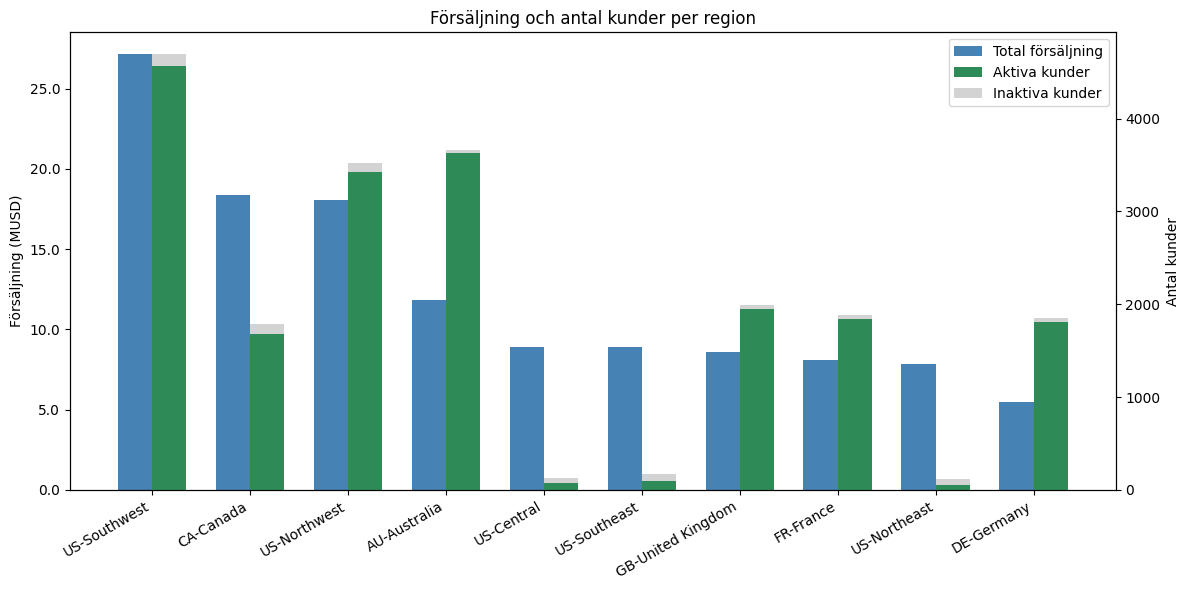

,Region,Total försäljning,Antal ordrar,Aktiva kunder,Inaktiva kunder,Unika kunder (totalt),Försäljning per aktiv kund
8,US-Northeast,"$7,820,210",352,57,56,113,"$137,197"
4,US-Central,"$8,913,299",385,69,63,132,"$129,178"
5,US-Southeast,"$8,884,099",486,91,85,176,"$97,627"
1,CA-Canada,"$18,398,929",4067,1677,114,1791,"$10,971"
0,US-Southwest,"$27,150,595",6224,4565,131,4696,"$5,948"
2,US-Northwest,"$18,061,660",4594,3428,92,3520,"$5,269"
7,FR-France,"$8,119,749",2672,1844,40,1884,"$4,403"
6,GB-United Kingdom,"$8,574,049",3219,1951,40,1991,"$4,395"
3,AU-Australia,"$11,814,376",6843,3625,40,3665,"$3,259"
9,DE-Germany,"$5,479,820",2623,1812,40,1852,"$3,024"


In [107]:
from matplotlib.patches import Patch

### Uppgift 6
# Försäljning och antal kunder per region
# Affärsfråga: Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?

query_6=""" 
SELECT
    CONCAT(st.CountryRegionCode,'-', st.Name) AS Region,
    COALESCE(SUM(soh.TotalDue), 0) AS TotalForsaljningRegion,
    COUNT(DISTINCT c.CustomerID) AS UnikaKunderTotalt,
    COUNT(DISTINCT soh.CustomerID) AS UnikaKunderMedOrder,
    COUNT(DISTINCT soh.SalesOrderID) AS AntalOrdrar
FROM Sales.SalesTerritory st
LEFT JOIN Sales.Customer c
    ON c.TerritoryID = st.TerritoryID
LEFT JOIN Sales.SalesOrderHeader soh
    ON soh.CustomerID = c.CustomerID
GROUP BY st.CountryRegionCode, st.Name
ORDER BY TotalForsaljningRegion DESC;
"""
df_6 = query_df(query_6)

df_6 = df_6.sort_values("TotalForsaljningRegion", ascending=False)
df_6.head()

df_6["InaktivaKunder"] = (df_6["UnikaKunderTotalt"] - df_6["UnikaKunderMedOrder"])

x = np.arange(len(df_6))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 6))

#stapel 1(försäljning)
bars_sales = ax1.bar(
    x - width/2,
    df_6["TotalForsaljningRegion"],
    width,
    label="Total försäljning",
    color="steelblue"
)

ax1.set_ylabel("Försäljning (MUSD)")
ax1.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda y, _: f"{y/1_000_000:.1f}")
)

#Stapel 2 kunder(akriva+inaktiva)
ax2 = ax1.twinx()

bars_inactive = ax2.bar(
    x + width/2,
    df_6["UnikaKunderMedOrder"],
    width,
    label="Aktiva kunder",
    color="seagreen"
)

bars_active = ax2.bar(
    x + width/2,
    df_6["InaktivaKunder"],
    width,
    bottom=df_6["UnikaKunderMedOrder"],
    label="Inaktiva kunder",
    color="lightgrey"
)

ax2.set_ylabel("Antal kunder")

ax1.set_xticks(x)
ax1.set_xticklabels(df_6["Region"], rotation=30, ha="right")

plt.title("Försäljning och antal kunder per region")

legend_handles = [
    Patch(facecolor="steelblue", label="Total försäljning"),
    Patch(facecolor="seagreen", label="Aktiva kunder"),
    Patch(facecolor="lightgrey", label="Inaktiva kunder")
]

ax1.legend(
    handles=legend_handles,
    loc="upper right"
)

plt.tight_layout()
plt.show()

df_6["ForsaljningPerAktivKund"] = df_6["TotalForsaljningRegion"]/df_6["UnikaKunderMedOrder"].replace(0, np.nan)

df_6_display=df_6.sort_values("ForsaljningPerAktivKund", ascending=False).copy()

cols = ["Region", "TotalForsaljningRegion", "AntalOrdrar", "UnikaKunderMedOrder", "InaktivaKunder", "UnikaKunderTotalt", "ForsaljningPerAktivKund"]
df_6_display=df_6_display[cols]

df_6_display = df_6_display.rename(columns={
    "TotalForsaljningRegion": "Total försäljning",
    "AntalOrdrar": "Antal ordrar",
    "UnikaKunderMedOrder": "Aktiva kunder",
    "InaktivaKunder": "Inaktiva kunder",
    "UnikaKunderTotalt": "Unika kunder (totalt)",
    "ForsaljningPerAktivKund": "Försäljning per aktiv kund",
})

#Markera max-raden
def highlight_max_sales(row):
    if row["Total försäljning"] == df_6_display["Total försäljning"].max():
        return ["font-weight: bold; color: orange"] * len(row)
    else:
        return [""] * len(row)

df_6_display.style \
    .apply(highlight_max_sales, axis=1) \
    .format({
    "Total försäljning": "${:,.0f} ",
    "Försäljning per aktiv kund": "${:,.0f} "
})


## Slutsats

US-Southwest är den starkaste regionen sett till total försäljning och kundvolym, där resultatet drivs av många kunder snarare än högt ordervärde per kund. Samtidigt uppvisar US-Central, US-Northeast och US-Southeast mycket hög försäljning per aktiv kund trots ett mycket begränsat antal kunder, vilket indikerar att försäljningen är koncentrerad till ett fåtal mycket stora affärer. Detta innebär hög intäkt per kund men också en högre affärsrisk. Regioner som EU och Australien har en bredare kundbas men betydligt lägre försäljning per kund, vilket tyder på en mer diversifierad och stabil försäljningsstruktur.

In [109]:
### Uppgift 7
# Genomsnittligt ordervärde per region och kundtyp
# Affärsfråga: Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?

query_7=""" 
SELECT
    CONCAT(st.CountryRegionCode,'-', st.Name) AS Region,
    CASE
        WHEN c.StoreID IS NOT NULL THEN 'Företagskund'
        WHEN c.PersonID IS NOT NULL THEN 'Privatkund'
    END AS Kundtyp,

    COALESCE(SUM(soh.TotalDue), 0) AS TotalForsaljning,
    COUNT(DISTINCT soh.CustomerID) AS UnikaKunderMedOrder,
    COUNT(soh.SalesOrderID) AS AntalOrdrar,
    AVG(soh.TotalDue) AS GenomsnittligtOrderVarde   
FROM Sales.SalesOrderHeader soh
JOIN Sales.Customer c
    ON soh.CustomerID = c.CustomerID
JOIN Sales.SalesTerritory st
    ON soh.TerritoryID = st.TerritoryID
LEFT JOIN Sales.Store s
    ON c.StoreID = s.BusinessEntityID
GROUP BY st.CountryRegionCode, st.Name,
    CASE
        WHEN c.StoreID IS NOT NULL THEN 'Företagskund'
        WHEN c.PersonID IS NOT NULL THEN 'Privatkund'
    END   
ORDER BY 
    GenomsnittligtOrdervarde DESC;
"""
df_7 = query_df(query_7)
df_7

,Region,Kundtyp,TotalForsaljning,UnikaKunderMedOrder,AntalOrdrar,GenomsnittligtOrderVarde
0,US-Southwest,Företagskund,2.083204e+07,115,751,27739.0649
1,FR-France,Företagskund,5.198110e+06,34,188,27649.5197
2,US-Northwest,Företagskund,1.402856e+07,87,536,26172.6823
3,GB-United Kingdom,Företagskund,4.826207e+06,38,188,25671.3118
4,US-Central,Företagskund,8.909983e+06,61,376,23696.7641
5,CA-Canada,Företagskund,1.621341e+07,106,692,23429.7839
6,US-Northeast,Företagskund,7.812991e+06,49,342,22845.0036
7,US-Southeast,Företagskund,8.870575e+06,79,469,18913.8069
8,DE-Germany,Företagskund,2.281604e+06,32,139,16414.4199
9,AU-Australia,Företagskund,1.801970e+06,34,125,14415.7618
